In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'  
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Embedding, Bidirectional, 
                                    LSTM, Dropout, BatchNormalization,
                                    SpatialDropout1D, Attention)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
from textaugment import EDA
import re
from spellchecker import SpellChecker
from tensorflow.keras import backend as K


In [2]:
# Initialize spell checker
spell = SpellChecker()


In [3]:

# 1. Text Cleaning Functions
def clean_text(text):
    # Correct common misspellings
    text = re.sub(r'\bhthere\b', 'hi there', text)
    text = re.sub(r'\bhtere\b', 'hi there', text)
    text = re.sub(r'\btheree\b', 'there', text)
    text = re.sub(r'\btere\b', 'there', text)
    text = re.sub(r'\bhow-do-you-do\b', 'hello', text)
    text = re.sub(r'\bhllo\b', 'hello', text)
    # Remove special characters and extra spaces
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text.lower()


In [4]:

# 2. Advanced Data Augmentation
def smart_augment(sentence, n=3):
    augmenter = EDA()
    augmented = []
    
    # Original cleaned sentence
    cleaned = clean_text(sentence)
    if cleaned not in augmented:
        augmented.append(cleaned)
    
    # Synonym replacement
    for _ in range(n):
        syn = augmenter.synonym_replacement(cleaned)
        if syn not in augmented:
            augmented.append(syn)
    
    # Random swap for longer sentences
    if len(cleaned.split()) > 3:
        for _ in range(n):
            swap = augmenter.random_swap(cleaned)
            if swap not in augmented:
                augmented.append(swap)
    
    return augmented


In [5]:

# 3. Load and Preprocess Data
def load_and_enhance_data(file_path):
    with open(file_path, encoding="utf-8") as file:
        data = json.load(file)
    
    training_sentences = []
    training_labels = []
    labels = []
    responses = []

    for intent in data['intents']:
        if len(intent['patterns']) >= 3:
            unique_patterns = list(set(intent['patterns']))  # Remove duplicates
            for pattern in unique_patterns:
                # Generate augmented variations
                augmented = smart_augment(pattern)
                training_sentences.extend(augmented)
                training_labels.extend([intent['tag']] * len(augmented))
            
            responses.append(intent['responses'])
            labels.append(intent['tag'])
    
    return training_sentences, training_labels, labels, responses


In [6]:

# 4. Load Enhanced Data
file_path = "intents[1].json"
training_sentences, training_labels, labels, responses = load_and_enhance_data(file_path)


In [7]:

# 5. Analyze Enhanced Data
print("\nEnhanced Class Distribution:")
print(pd.Series(training_labels).value_counts())

# 6. Label Encoding
label_encoder = LabelEncoder()
training_labels = label_encoder.fit_transform(training_labels)
num_classes = len(labels)
print(f"\nNumber of Classes: {num_classes}")

# 7. Improved Tokenization
vocab_size = 2000
max_len = 15
embedding_dim = 128

tokenizer = Tokenizer(
    num_words=vocab_size,
    oov_token="<OOV>",
    filters=''
)
tokenizer.fit_on_texts(training_sentences)
sequences = tokenizer.texts_to_sequences(training_sentences)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')



Enhanced Class Distribution:
music_play         6430
jokes              4715
suicide            4598
datetime_query     4517
sleep              4509
                   ... 
evening              45
arabic_greeting      42
yes                  32
noanswer             22
no                   13
Name: count, Length: 290, dtype: int64

Number of Classes: 306


In [8]:

# 8. Data Splitting
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences,
    training_labels,
    test_size=0.15,
    random_state=42,
    stratify=training_labels
)

# 9. Calculate Class Weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(training_labels),
    y=training_labels
)
class_weight = dict(enumerate(class_weights))


In [9]:
def build_smarter_model():
    inputs = keras.Input(shape=(max_len,))
    x = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs)
    x = SpatialDropout1D(0.3)(x)
    
    # Bidirectional LSTM with return_sequences=True
    lstm_out = Bidirectional(LSTM(64, return_sequences=True))(x)  # Shape: [batch, seq_len, 128]

    # Self-Attention using Dot Product
    from tensorflow.keras.layers import Dense, Layer
    class SelfAttention(keras.layers.Layer):
        def __init__(self, units, **kwargs):
            super().__init__(**kwargs)
            self.units = units
            self.query = Dense(units)
            self.key = Dense(units)
            self.value = Dense(units)

        def call(self, inputs):
            q = self.query(inputs)   # (batch, seq_len, units)
            k = self.key(inputs)     # (batch, seq_len, units)
            v = self.value(inputs)   # (batch, seq_len, units)

            # Dot product attention
            scores = tf.matmul(q, k, transpose_b=True) / tf.math.sqrt(tf.cast(self.units, tf.float32))
            weights = tf.nn.softmax(scores, axis=-1)
            output = tf.matmul(weights, v)
            return output

    attn_out = SelfAttention(units=64)(lstm_out)  # units يمكن أن تساوي 128
    
    # Global pooling after attention
    x = tf.keras.layers.GlobalAveragePooling1D()(attn_out)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    optimizer = keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [10]:

model = build_smarter_model()
model.summary()


e:\anaconda\Lib\site-packages\keras\src\layers\layer.py:939: UserWarning: Layer 'self_attention' (of type SelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 15, 128)   │    256,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 15, 128)   │          0 │ embedding[0][0]   │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 15)        │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 15, 128)   │     98,816 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ self_attention      │ (None, 15, 64)    │     24,768 │ bidirectional[0]… │
│ (SelfAttention)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ self_attention[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64)        │        256 │ global_average_p… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      4,160 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 306)       │     19,890 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 404,146 (1.54 MB)

 Trainable params: 403,890 (1.54 MB)

 Non-trainable params: 256 (1.00 KB)

In [11]:

# 11. Training with Enhanced Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=20,
        mode='max',
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        'best_chatbot_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]


In [12]:

# 12. Train the Enhanced Model
print("\nStarting enhanced training...")
history = model.fit(
    X_train, y_train,
    epochs=130,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    class_weight=class_weight,  # استخدم القاموس هنا
    verbose=2
)



Starting enhanced training...
Epoch 1/130

Epoch 1: val_accuracy improved from -inf to 0.82364, saving model to best_chatbot_model.h5


20857/20857 - 672s - 32ms/step - accuracy: 0.6211 - loss: 1.6622 - val_accuracy: 0.8236 - val_loss: 0.5294 - learning_rate: 5.0000e-04
Epoch 2/130

Epoch 2: val_accuracy improved from 0.82364 to 0.85972, saving model to best_chatbot_model.h5


20857/20857 - 662s - 32ms/step - accuracy: 0.7582 - loss: 0.8739 - val_accuracy: 0.8597 - val_loss: 0.3719 - learning_rate: 5.0000e-04
Epoch 3/130

Epoch 3: val_accuracy improved from 0.85972 to 0.86127, saving model to best_chatbot_model.h5


20857/20857 - 35639s - 2s/step - accuracy: 0.7825 - loss: 0.7795 - val_accuracy: 0.8613 - val_loss: 0.3694 - learning_rate: 5.0000e-04
Epoch 4/130

Epoch 4: val_accuracy improved from 0.86127 to 0.86757, saving model to best_chatbot_model.h5


20857/20857 - 637s - 31ms/step - accuracy: 0.7958 - loss: 0.7205 - val_accuracy: 0.8676 - val_loss: 0.3351 - learning_rate: 5.0000e-04
Epoch 5/130

Epoch 5: val_accuracy improved from 0.86757 to 0.86887, saving model to best_chatbot_model.h5


20857/20857 - 632s - 30ms/step - accuracy: 0.8049 - loss: 0.6869 - val_accuracy: 0.8689 - val_loss: 0.3317 - learning_rate: 5.0000e-04
Epoch 6/130

Epoch 6: val_accuracy improved from 0.86887 to 0.87317, saving model to best_chatbot_model.h5


20857/20857 - 6533s - 313ms/step - accuracy: 0.8129 - loss: 0.6601 - val_accuracy: 0.8732 - val_loss: 0.3266 - learning_rate: 5.0000e-04
Epoch 7/130

Epoch 7: val_accuracy improved from 0.87317 to 0.87449, saving model to best_chatbot_model.h5


20857/20857 - 620s - 30ms/step - accuracy: 0.8192 - loss: 0.6346 - val_accuracy: 0.8745 - val_loss: 0.3206 - learning_rate: 5.0000e-04
Epoch 8/130

Epoch 8: val_accuracy improved from 0.87449 to 0.87742, saving model to best_chatbot_model.h5


20857/20857 - 633s - 30ms/step - accuracy: 0.8247 - loss: 0.6182 - val_accuracy: 0.8774 - val_loss: 0.3103 - learning_rate: 5.0000e-04
Epoch 9/130

Epoch 9: val_accuracy did not improve from 0.87742
20857/20857 - 33336s - 2s/step - accuracy: 0.8288 - loss: 0.6050 - val_accuracy: 0.8765 - val_loss: 0.3111 - learning_rate: 5.0000e-04
Epoch 10/130

Epoch 10: val_accuracy improved from 0.87742 to 0.87859, saving model to best_chatbot_model.h5


20857/20857 - 682s - 33ms/step - accuracy: 0.8323 - loss: 0.5882 - val_accuracy: 0.8786 - val_loss: 0.3055 - learning_rate: 5.0000e-04
Epoch 11/130

Epoch 11: val_accuracy improved from 0.87859 to 0.88227, saving model to best_chatbot_model.h5


20857/20857 - 1068s - 51ms/step - accuracy: 0.8358 - loss: 0.5770 - val_accuracy: 0.8823 - val_loss: 0.2975 - learning_rate: 5.0000e-04
Epoch 12/130

Epoch 12: val_accuracy did not improve from 0.88227
20857/20857 - 1424s - 68ms/step - accuracy: 0.8382 - loss: 0.5685 - val_accuracy: 0.8812 - val_loss: 0.2915 - learning_rate: 5.0000e-04
Epoch 13/130

Epoch 13: val_accuracy improved from 0.88227 to 0.88470, saving model to best_chatbot_model.h5


20857/20857 - 1228s - 59ms/step - accuracy: 0.8406 - loss: 0.5604 - val_accuracy: 0.8847 - val_loss: 0.2965 - learning_rate: 5.0000e-04
Epoch 14/130

Epoch 14: val_accuracy improved from 0.88470 to 0.88947, saving model to best_chatbot_model.h5


20857/20857 - 1120s - 54ms/step - accuracy: 0.8430 - loss: 0.5496 - val_accuracy: 0.8895 - val_loss: 0.2852 - learning_rate: 5.0000e-04
Epoch 15/130

Epoch 15: val_accuracy did not improve from 0.88947
20857/20857 - 1099s - 53ms/step - accuracy: 0.8448 - loss: 0.5469 - val_accuracy: 0.8845 - val_loss: 0.2878 - learning_rate: 5.0000e-04
Epoch 16/130

Epoch 16: val_accuracy did not improve from 0.88947
20857/20857 - 1072s - 51ms/step - accuracy: 0.8470 - loss: 0.5376 - val_accuracy: 0.8869 - val_loss: 0.2875 - learning_rate: 5.0000e-04
Epoch 17/130

Epoch 17: val_accuracy did not improve from 0.88947
20857/20857 - 1063s - 51ms/step - accuracy: 0.8499 - loss: 0.5286 - val_accuracy: 0.8893 - val_loss: 0.2791 - learning_rate: 5.0000e-04
Epoch 18/130

Epoch 18: val_accuracy did not improve from 0.88947
20857/20857 - 1059s - 51ms/step - accuracy: 0.8514 - loss: 0.5271 - val_accuracy: 0.8894 - val_loss: 0.2800 - learning_rate: 5.0000e-04
Epoch 19/130

Epoch 19: val_accuracy did not improve fro

20857/20857 - 1067s - 51ms/step - accuracy: 0.8529 - loss: 0.5148 - val_accuracy: 0.8896 - val_loss: 0.2753 - learning_rate: 5.0000e-04
Epoch 21/130

Epoch 21: val_accuracy improved from 0.88962 to 0.89175, saving model to best_chatbot_model.h5


20857/20857 - 1077s - 52ms/step - accuracy: 0.8547 - loss: 0.5203 - val_accuracy: 0.8917 - val_loss: 0.2720 - learning_rate: 5.0000e-04
Epoch 22/130

Epoch 22: val_accuracy did not improve from 0.89175
20857/20857 - 1078s - 52ms/step - accuracy: 0.8555 - loss: 0.5146 - val_accuracy: 0.8914 - val_loss: 0.2751 - learning_rate: 5.0000e-04
Epoch 23/130

Epoch 23: val_accuracy did not improve from 0.89175
20857/20857 - 1039s - 50ms/step - accuracy: 0.8570 - loss: 0.5071 - val_accuracy: 0.8914 - val_loss: 0.2737 - learning_rate: 5.0000e-04
Epoch 24/130

Epoch 24: val_accuracy improved from 0.89175 to 0.89382, saving model to best_chatbot_model.h5


20857/20857 - 1004s - 48ms/step - accuracy: 0.8573 - loss: 0.5014 - val_accuracy: 0.8938 - val_loss: 0.2654 - learning_rate: 5.0000e-04
Epoch 25/130

Epoch 25: val_accuracy did not improve from 0.89382
20857/20857 - 1111s - 53ms/step - accuracy: 0.8581 - loss: 0.4986 - val_accuracy: 0.8930 - val_loss: 0.2655 - learning_rate: 5.0000e-04
Epoch 26/130

Epoch 26: val_accuracy improved from 0.89382 to 0.89453, saving model to best_chatbot_model.h5


20857/20857 - 1024s - 49ms/step - accuracy: 0.8603 - loss: 0.4997 - val_accuracy: 0.8945 - val_loss: 0.2700 - learning_rate: 5.0000e-04
Epoch 27/130

Epoch 27: val_accuracy did not improve from 0.89453
20857/20857 - 1075s - 52ms/step - accuracy: 0.8603 - loss: 0.4921 - val_accuracy: 0.8937 - val_loss: 0.2686 - learning_rate: 5.0000e-04
Epoch 28/130

Epoch 28: val_accuracy did not improve from 0.89453
20857/20857 - 1041s - 50ms/step - accuracy: 0.8608 - loss: 0.4964 - val_accuracy: 0.8944 - val_loss: 0.2682 - learning_rate: 5.0000e-04
Epoch 29/130

Epoch 29: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 29: val_accuracy did not improve from 0.89453
20857/20857 - 1076s - 52ms/step - accuracy: 0.8616 - loss: 0.4881 - val_accuracy: 0.8944 - val_loss: 0.2694 - learning_rate: 5.0000e-04
Epoch 30/130

Epoch 30: val_accuracy improved from 0.89453 to 0.89929, saving model to best_chatbot_model.h5


20857/20857 - 1050s - 50ms/step - accuracy: 0.8694 - loss: 0.4516 - val_accuracy: 0.8993 - val_loss: 0.2549 - learning_rate: 1.0000e-04
Epoch 31/130

Epoch 31: val_accuracy did not improve from 0.89929
20857/20857 - 981s - 47ms/step - accuracy: 0.8729 - loss: 0.4421 - val_accuracy: 0.8991 - val_loss: 0.2544 - learning_rate: 1.0000e-04
Epoch 32/130

Epoch 32: val_accuracy improved from 0.89929 to 0.89975, saving model to best_chatbot_model.h5


20857/20857 - 1077s - 52ms/step - accuracy: 0.8747 - loss: 0.4333 - val_accuracy: 0.8997 - val_loss: 0.2528 - learning_rate: 1.0000e-04
Epoch 33/130

Epoch 33: val_accuracy improved from 0.89975 to 0.90149, saving model to best_chatbot_model.h5


20857/20857 - 1105s - 53ms/step - accuracy: 0.8754 - loss: 0.4309 - val_accuracy: 0.9015 - val_loss: 0.2497 - learning_rate: 1.0000e-04
Epoch 34/130

Epoch 34: val_accuracy did not improve from 0.90149
20857/20857 - 1062s - 51ms/step - accuracy: 0.8766 - loss: 0.4295 - val_accuracy: 0.9010 - val_loss: 0.2510 - learning_rate: 1.0000e-04
Epoch 35/130

Epoch 35: val_accuracy did not improve from 0.90149
20857/20857 - 1068s - 51ms/step - accuracy: 0.8775 - loss: 0.4216 - val_accuracy: 0.9005 - val_loss: 0.2512 - learning_rate: 1.0000e-04
Epoch 36/130

Epoch 36: val_accuracy improved from 0.90149 to 0.90155, saving model to best_chatbot_model.h5


20857/20857 - 1070s - 51ms/step - accuracy: 0.8777 - loss: 0.4262 - val_accuracy: 0.9015 - val_loss: 0.2503 - learning_rate: 1.0000e-04
Epoch 37/130

Epoch 37: val_accuracy did not improve from 0.90155
20857/20857 - 1102s - 53ms/step - accuracy: 0.8776 - loss: 0.4220 - val_accuracy: 0.9008 - val_loss: 0.2502 - learning_rate: 1.0000e-04
Epoch 38/130

Epoch 38: ReduceLROnPlateau reducing learning rate to 2.0000000949949027e-05.

Epoch 38: val_accuracy did not improve from 0.90155
20857/20857 - 1072s - 51ms/step - accuracy: 0.8792 - loss: 0.4170 - val_accuracy: 0.9013 - val_loss: 0.2501 - learning_rate: 1.0000e-04
Epoch 39/130

Epoch 39: val_accuracy improved from 0.90155 to 0.90217, saving model to best_chatbot_model.h5


20857/20857 - 1078s - 52ms/step - accuracy: 0.8809 - loss: 0.4131 - val_accuracy: 0.9022 - val_loss: 0.2462 - learning_rate: 2.0000e-05
Epoch 40/130

Epoch 40: val_accuracy improved from 0.90217 to 0.90226, saving model to best_chatbot_model.h5


20857/20857 - 1127s - 54ms/step - accuracy: 0.8810 - loss: 0.4114 - val_accuracy: 0.9023 - val_loss: 0.2472 - learning_rate: 2.0000e-05
Epoch 41/130

Epoch 41: val_accuracy improved from 0.90226 to 0.90295, saving model to best_chatbot_model.h5


20857/20857 - 1078s - 52ms/step - accuracy: 0.8820 - loss: 0.4069 - val_accuracy: 0.9030 - val_loss: 0.2450 - learning_rate: 2.0000e-05
Epoch 42/130

Epoch 42: val_accuracy improved from 0.90295 to 0.90328, saving model to best_chatbot_model.h5


20857/20857 - 1153s - 55ms/step - accuracy: 0.8819 - loss: 0.4079 - val_accuracy: 0.9033 - val_loss: 0.2459 - learning_rate: 2.0000e-05
Epoch 43/130

Epoch 43: val_accuracy did not improve from 0.90328
20857/20857 - 1091s - 52ms/step - accuracy: 0.8827 - loss: 0.4084 - val_accuracy: 0.9032 - val_loss: 0.2440 - learning_rate: 2.0000e-05
Epoch 44/130

Epoch 44: val_accuracy did not improve from 0.90328
20857/20857 - 1098s - 53ms/step - accuracy: 0.8819 - loss: 0.4065 - val_accuracy: 0.9028 - val_loss: 0.2458 - learning_rate: 2.0000e-05
Epoch 45/130

Epoch 45: val_accuracy improved from 0.90328 to 0.90370, saving model to best_chatbot_model.h5


20857/20857 - 1092s - 52ms/step - accuracy: 0.8820 - loss: 0.4095 - val_accuracy: 0.9037 - val_loss: 0.2453 - learning_rate: 2.0000e-05
Epoch 46/130

Epoch 46: val_accuracy improved from 0.90370 to 0.90377, saving model to best_chatbot_model.h5


20857/20857 - 1130s - 54ms/step - accuracy: 0.8826 - loss: 0.4069 - val_accuracy: 0.9038 - val_loss: 0.2450 - learning_rate: 2.0000e-05
Epoch 47/130

Epoch 47: val_accuracy improved from 0.90377 to 0.90396, saving model to best_chatbot_model.h5


20857/20857 - 1148s - 55ms/step - accuracy: 0.8828 - loss: 0.4034 - val_accuracy: 0.9040 - val_loss: 0.2453 - learning_rate: 2.0000e-05
Epoch 48/130

Epoch 48: ReduceLROnPlateau reducing learning rate to 4.000000262749381e-06.

Epoch 48: val_accuracy improved from 0.90396 to 0.90425, saving model to best_chatbot_model.h5


20857/20857 - 1155s - 55ms/step - accuracy: 0.8829 - loss: 0.4053 - val_accuracy: 0.9042 - val_loss: 0.2447 - learning_rate: 2.0000e-05
Epoch 49/130

Epoch 49: val_accuracy did not improve from 0.90425
20857/20857 - 1079s - 52ms/step - accuracy: 0.8835 - loss: 0.4046 - val_accuracy: 0.9038 - val_loss: 0.2450 - learning_rate: 4.0000e-06
Epoch 50/130

Epoch 50: val_accuracy did not improve from 0.90425
20857/20857 - 1120s - 54ms/step - accuracy: 0.8827 - loss: 0.4047 - val_accuracy: 0.9040 - val_loss: 0.2449 - learning_rate: 4.0000e-06
Epoch 51/130

Epoch 51: val_accuracy improved from 0.90425 to 0.90447, saving model to best_chatbot_model.h5


20857/20857 - 1097s - 53ms/step - accuracy: 0.8826 - loss: 0.3992 - val_accuracy: 0.9045 - val_loss: 0.2449 - learning_rate: 4.0000e-06
Epoch 52/130

Epoch 52: val_accuracy did not improve from 0.90447
20857/20857 - 1076s - 52ms/step - accuracy: 0.8838 - loss: 0.4036 - val_accuracy: 0.9039 - val_loss: 0.2444 - learning_rate: 4.0000e-06
Epoch 53/130

Epoch 53: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 53: val_accuracy did not improve from 0.90447
20857/20857 - 1184s - 57ms/step - accuracy: 0.8833 - loss: 0.4026 - val_accuracy: 0.9040 - val_loss: 0.2444 - learning_rate: 4.0000e-06
Epoch 54/130

Epoch 54: val_accuracy did not improve from 0.90447
20857/20857 - 1010s - 48ms/step - accuracy: 0.8827 - loss: 0.3995 - val_accuracy: 0.9037 - val_loss: 0.2446 - learning_rate: 1.0000e-06
Epoch 55/130

Epoch 55: val_accuracy did not improve from 0.90447
20857/20857 - 1307s - 63ms/step - accuracy: 0.8833 - loss: 0.4025 - val_accuracy: 0.9039 - val_loss: 0.2445 - learning_rate: 1.000

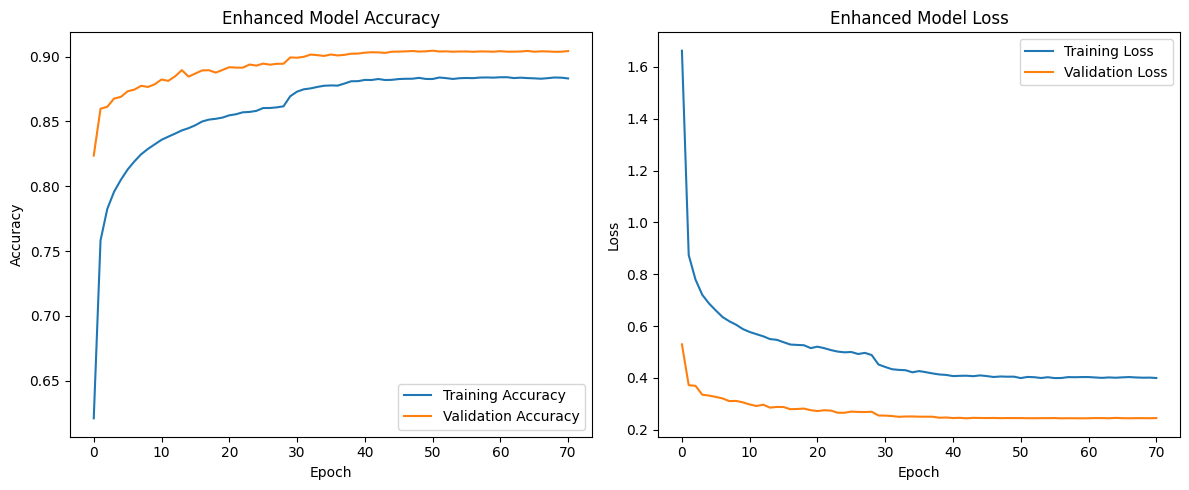

In [13]:

# 13. Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Enhanced Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Enhanced Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:

# 14. Save Enhanced Model
model.save("enhanced_chatbot_model.keras")
with open("enhanced_tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
with open("enhanced_label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

print("\nEnhanced training completed successfully!")
print(f"Best training accuracy: {max(history.history['accuracy']):.4f}")
print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")
# save the model and tokenizer
print("Model and tokenizer saved successfully!")


# 15. Clear Keras Session


Enhanced training completed successfully!
Best training accuracy: 0.8840
Best validation accuracy: 0.9045
Model and tokenizer saved successfully!
